In [1]:
import torch
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import random

import torch.nn as nn
from torch.optim import Adam
from torchvision import datasets, models
from load_dataset import BangladeshDataset, BangladeshDatasetJpegs, IndiaDataset

from utils import torch_to_im_show
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
def preprocess(img):
    transform = T.Compose([
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        #T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        #T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled

def normalize_image(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    return inp

In [3]:
def compute_saliency_maps(X, y, model):
    """
    Compute an expenditure saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Wrap the input tensors in Variables
    X_var = Variable(X, requires_grad=True)
    y_var = Variable(y)
    saliency = None
    ##############################################################################
    #       Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the predicted expenditure with        #
    # respect to each input image. You first want to compute the loss over the   #
    # prediction, and then compute the gradients with a backward pass.           #
    ##############################################################################
    outputs = model(X_var)
    preds = outputs.data
    criterion = nn.MSELoss()
    loss = criterion(outputs, y_var)
    loss.backward()
    gradients = X_var.grad
    saliency, _ = torch.max(gradients.abs(), 1)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency.data.squeeze(), preds

In [5]:
def show_saliency_maps(X, y, model):
    # Convert X and y from numpy arrays to Torch Tensors
    #X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    #y_tensor = torch.FloatTensor(y)
    X_tensor = X.float()
    y_tensor = y.float()

    # Compute saliency maps for images in X
    saliency, preds = compute_saliency_maps(X_tensor, y_tensor, model)
    #print(saliency)
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    preds = preds.numpy()
    
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(normalize_image(X_tensor[i]))
        plt.axis('off')
        plt.title('True Expenditure: {}\n Pred Expenditure: {}'.format(int(y[i] * 0.015), int(preds[i])))
        plt.subplot(2, N, N + i + 1)
        print(np.amax(saliency[i].squeeze()), np.amin(saliency[i].squeeze()))
        plt.imshow(saliency[i].squeeze(), cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()
    

In [6]:
def show_images(X):    
    N = X.shape[0]
    for i in range(N):
        inp = X[i]
        inp = normalize_image(inp)
        
        plt.subplot(2, N, i + 1)
        plt.imshow(inp)
        plt.axis('off')
        plt.title('Sample #{}'.format(i))
        plt.gcf().set_size_inches(12, 5)
    plt.show()

In [7]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.resnet18(pretrained=False)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features

# 1 since we are only predicting household expenditure
model.fc = nn.Linear(num_ftrs, 1)

model.load_state_dict(torch.load("/home/echartock03/predicting-poverty/models/india_s1.model"))

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

In [8]:
#val_data_dir = '/mnt/mounted_bucket'
#val_bangladesh_csv_path = '/home/echartock03/predicting-poverty/data/bangladesh_2015_valid.csv'

#val_dataset = BangladeshDataset(csv_file=val_bangladesh_csv_path, root_dir=val_data_dir)

data_transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    #T.Lambda(lambda x: x[None]),
])

val_data_dir = '/home/echartock03/data/india_s1_2015'
val_india_csv_path = '../data/india_subset.csv'

val_dataset = IndiaDataset(csv_file=val_india_csv_path, root_dir=val_data_dir, transform=None, sat_type="s1")

dataset_size = len(val_dataset)
print(dataset_size)

3


(0, (500, 500, 3), 28561.503910000003)
(1, (500, 500, 3), 22370.341799999998)
(2, (500, 500, 3), 22230.28125)


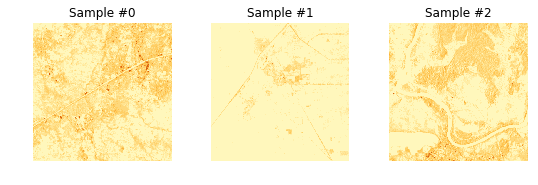

In [9]:
for i in range(len(val_dataset)):
    image, label = val_dataset[i]
    image = np.array(image)

    print(i, image.shape, label)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    
    # expects images with shape image.shape = (500, 500, 3)
    plt.imshow(image)
    plt.pause(0.001)  # pause a bit so that plots are updated

    if i == 3:
        plt.show()
        break

In [10]:
val_dataset = IndiaDataset(csv_file=val_india_csv_path, root_dir=val_data_dir, transform=data_transform, sat_type="s1")

dataloder = torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                             shuffle=False, num_workers=1)

(164473.97, 15.655365)
(68731.57, 5.0362778)
(178265.22, 19.649323)


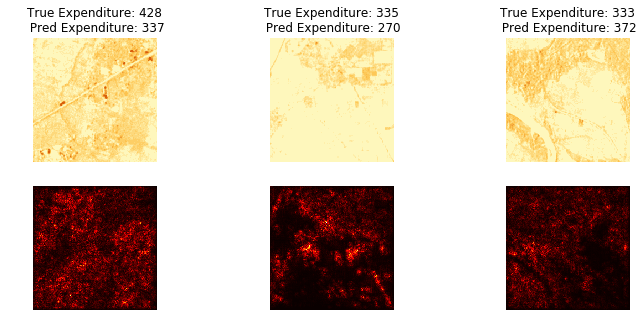

In [11]:
# visualize a random batch worth of images
images, labels = next(iter(dataloder))
# out = torchvision.utils.make_grid(images)
# show_images(images)
show_saliency_maps(images, labels, model)